# San Francisco Crime Classification

**Authors**: Chiara Angileri, Livia Del Gaudio, Giorgia Pavani

### Import libraries

In [1]:
%%capture
!pip install scikit-learn
!pip install geopandas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import *

from pyspark.ml import Pipeline

from pyspark.ml.feature import *

from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes, LogisticRegression, RandomForestClassifier, GBTClassifier, FMClassifier, OneVsRest, MultilayerPerceptronClassifier
 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

# Fix seed for reproducibility
seed = 1234

ModuleNotFoundError: No module named 'geopandas'

In [3]:
# spark session 
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# to suppress warnings
spark.sparkContext.setLogLevel("ERROR")

# TODO: togliere prima di consegnare

In [4]:
# load sfcrime and sfcrime_tfidf
sfcrime = spark.table("sfcrime_processed")
sfcrime_tfidf = spark.table("sfcrime_tfidf_processed")

# Load the data

In [2]:
def load_data(split):
    df = spark.read.format("csv")\
                    .option("sep", ",")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path",f"bigdata/Project/dataset/{split}.csv").load()
    return df

In [3]:
df_sfcrime = load_data("train")
df_sfcrime.printSchema()

root
 |-- Dates: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)



In [6]:
# Visualize the data
df_sfcrime.show(5)

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

**Data fields**:
- *Dates*: timestamp of the crime incident.
- *Category*: category of the crime incident. **Target variable** we are going to predict.
- *Descript*: detailed description of the crime incident.
- *DayOfWeek*: the day of the week.
- *PdDistrict*: name of the Police Department District.
- *Resolution*: how the crime incident was resolved.
- *Address*: the approximate street address of the crime incident.
- *X*: longitude.
- *Y*: latitude.

# Data Preprocessing

Steps done in preprocessing:
- **Feature extraction**: extract Hour, Month, and Year from the 'Dates' column in the DataFrame.
- **Drop duplicate rows**
- **Nulls removal**
- **Outliers removal**: filter out outliers based on specified criteria for latitude and longitude values ('X' and 'Y' coordinates).
- **Normalize coordinates**: normalize 'X' and 'Y' coordinates using MinMaxScaler to transform the values between 0 and 1.
- **Drop unused columns**

In [4]:
def plot_outliers(df):
    sfcrime_pd = df.toPandas()

    geometry = [Point(xy) for xy in zip(sfcrime_pd['X'], sfcrime_pd['Y'])]
    gdf = GeoDataFrame(sfcrime_pd, geometry=geometry)

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gdf.plot(ax=world.plot(), marker='o', color='red')
    plt.show()

Number of duplicated rows:  2323


/tmp/ipykernel_75/2513558969.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


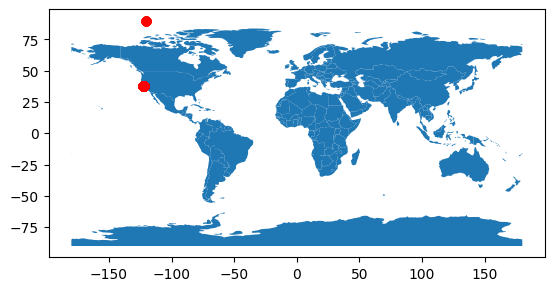

Number of outliers:  67


In [5]:
# Extract features from date 
df_sfcrime = df_sfcrime.withColumn('Hour', hour("Dates"))\
        .withColumn('Month', month("Dates"))\
        .withColumn('Year', year("Dates"))

# Drop duplicate rows
prev_count = df_sfcrime.count()
df_sfcrime = df_sfcrime.dropDuplicates()
print(f"Number of duplicated rows: ", prev_count - df_sfcrime.count())

# Nulls removal
df_sfcrime.na.drop()

# Outliers removal
plot_outliers(df_sfcrime) 
prev_count = df_sfcrime.count()
df_sfcrime = df_sfcrime.where((df_sfcrime.X < -122) & (df_sfcrime.X > -123) & (df_sfcrime.Y < 38) & (df_sfcrime.Y > 37))
print(f"Number of outliers: ", prev_count - df_sfcrime.count())
    
# Normalize X and Y coordinates 
for i in ["X","Y"]:
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")
    pipeline = Pipeline(stages=[assembler, scaler])
    df_sfcrime = pipeline.fit(df_sfcrime).transform(df_sfcrime)

# Drop unused columns
df_sfcrime = df_sfcrime.drop("Dates")
df_sfcrime = df_sfcrime.drop("X_Vect","Y_Vect", "X", "Y")

From the previous image, we can observe that there are some erroneus coordinates that do not refer to San Francisco geographic coordinates. They may be due to mislabelling errors, and we consider them as outliers, therefore we remove them from the dataset. 

In [9]:
# Visualize the data
df_sfcrime.show()

+--------------+--------------------+---------+----------+--------------+--------------------+----+-----+----+--------------------+--------------------+
|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|Hour|Month|Year|            X_Scaled|            Y_Scaled|
+--------------+--------------------+---------+----------+--------------+--------------------+----+-----+----+--------------------+--------------------+
|      BURGLARY|BURGLARY, UNLAWFU...|Wednesday|  NORTHERN|          NONE|2300 Block of FIL...|  13|    5|2015|[0.5331389416346913]|[0.7428616292488223]|
| VEHICLE THEFT|   STOLEN AUTOMOBILE|  Tuesday| INGLESIDE|          NONE|ALEMANY BL / ONON...|  21|    5|2015|[0.5043534508595877]|[0.12263853306963...|
| LARCENY/THEFT|GRAND THEFT FROM ...|   Monday|  NORTHERN|          NONE|   BUSH ST / POLK ST|  21|    5|2015|[0.6276519170675439]|[0.7209854943264132]|
| LARCENY/THEFT|GRAND THEFT SHOPL...|   Monday|  SOUTHERN|          NONE|700 Block

# Dataset inspection

We split the dataset into train and test, in order to inspect only the train set.

In [10]:
# Split the data into train and test (to inspect only the train set)
sfcrime_train, sfcrime_test = df_sfcrime.randomSplit([0.7, 0.3], seed=seed)

In [11]:
plot = True
if plot:
    sfcrime_train_pd = sfcrime_train.toPandas().copy()
    
    # Select the top 10 crimes and group the rest into 'Other crimes'
    top10 = sfcrime_train_pd['Category'].value_counts().head(10).index.tolist()
    sfcrime_train_top_10 = sfcrime_train_pd.copy()
    sfcrime_train_top_10.loc[~sfcrime_train_pd['Category'].isin(top10), 'Category'] = 'Other crimes'


### Distribution of crimes

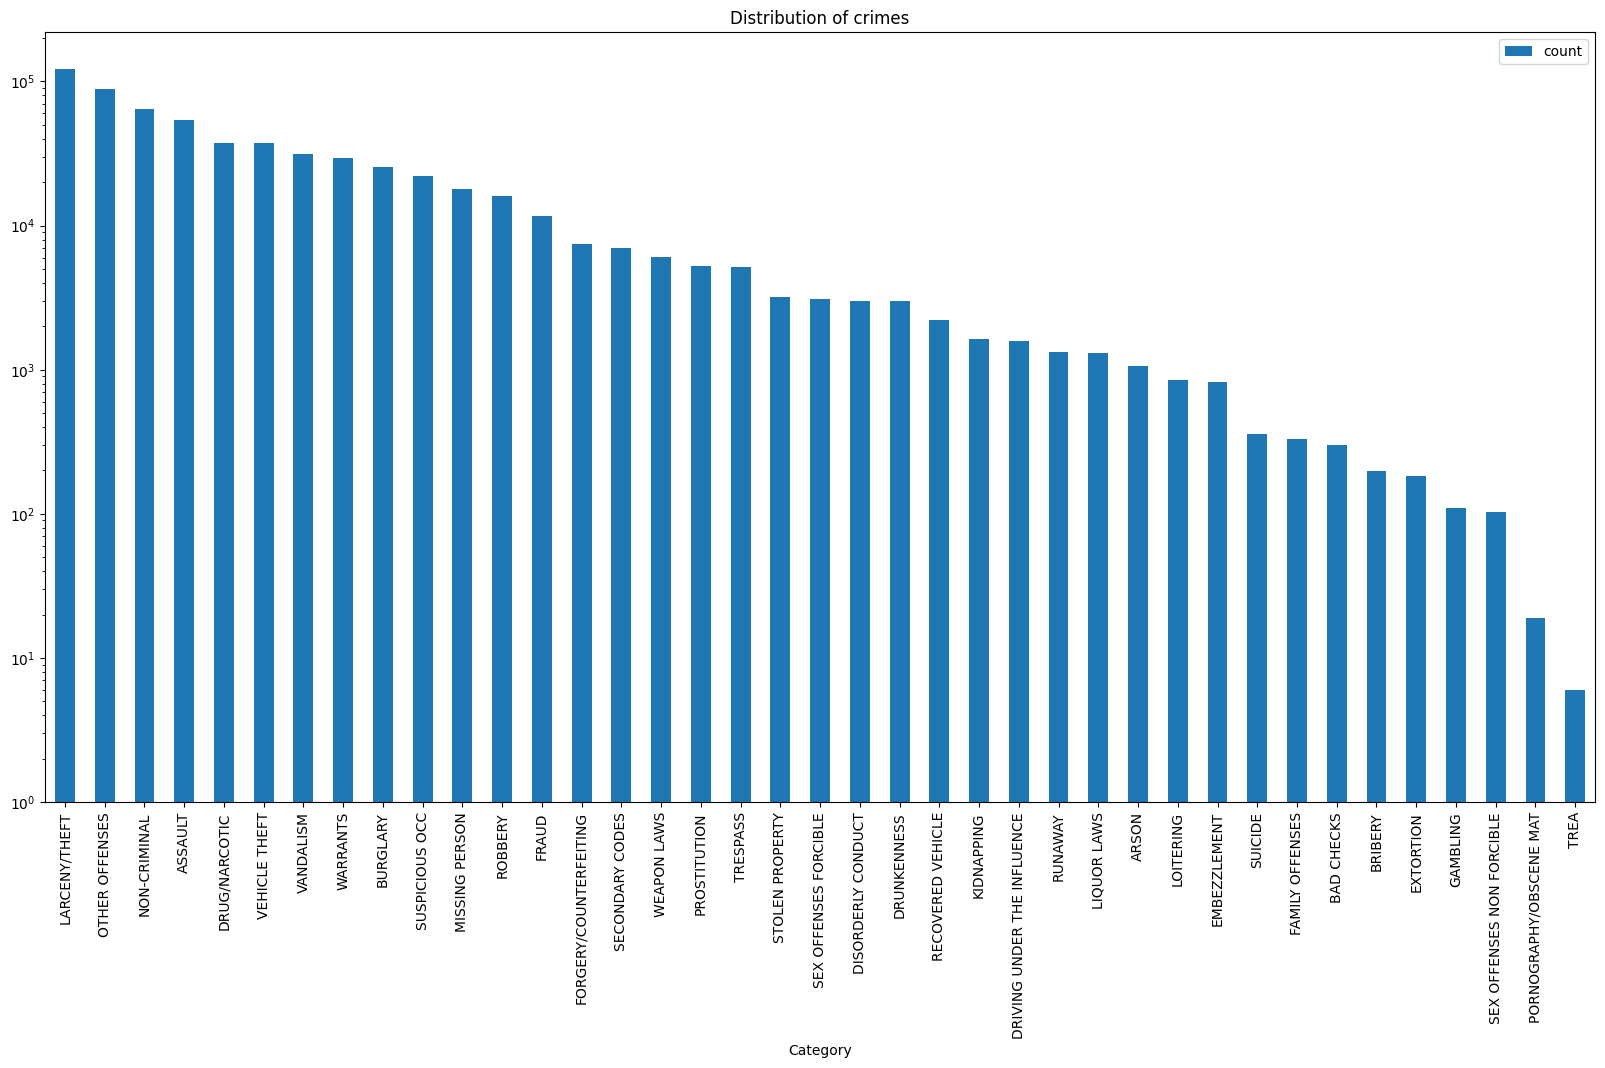

In [12]:
def crime_distribution(df, plot = True):
    if plot:
        df.groupBy("Category").count().orderBy("count", ascending=False).toPandas().plot(kind='bar', x='Category', y='count', log=True, figsize=(20,10))
        plt.title('Distribution of crimes')
        plt.show()

crime_distribution(sfcrime_train, plot = plot)    

### Distributions of crimes among districts

From this graphical view we can observe that criminality is not fairly distributed among districts, for example Southern district has more than 100000 crimes whereas Richmond has less than 4000 crimes.

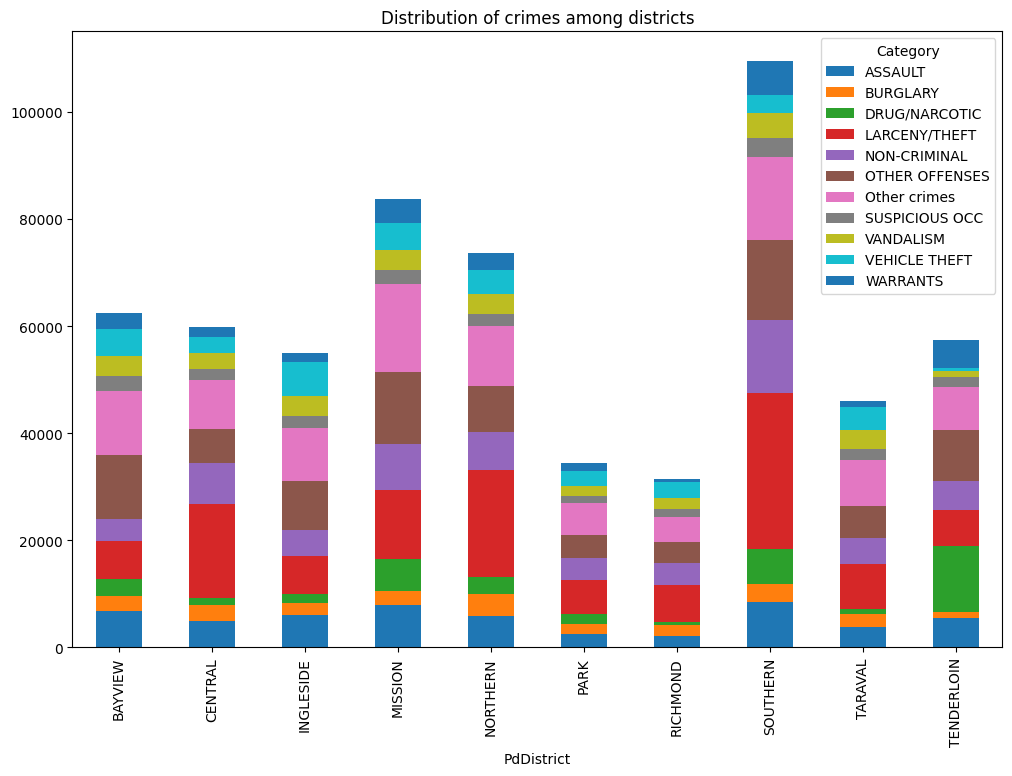

In [13]:
def crime_distribution_among_districts(df, df_copy_top_10, plot = True):
    if plot:
        df_copy_top_10.groupby(['PdDistrict','Category'])\
                    .agg({'Resolution':'count'})\
                    .pivot_table(index='PdDistrict',columns='Category')['Resolution']\
                    .plot(kind='bar',stacked=True,figsize=(12,8))
        plt.title('Distribution of crimes among districts')

crime_distribution_among_districts(sfcrime_train, sfcrime_train_top_10, plot = plot)

### Distribution of crimes among years

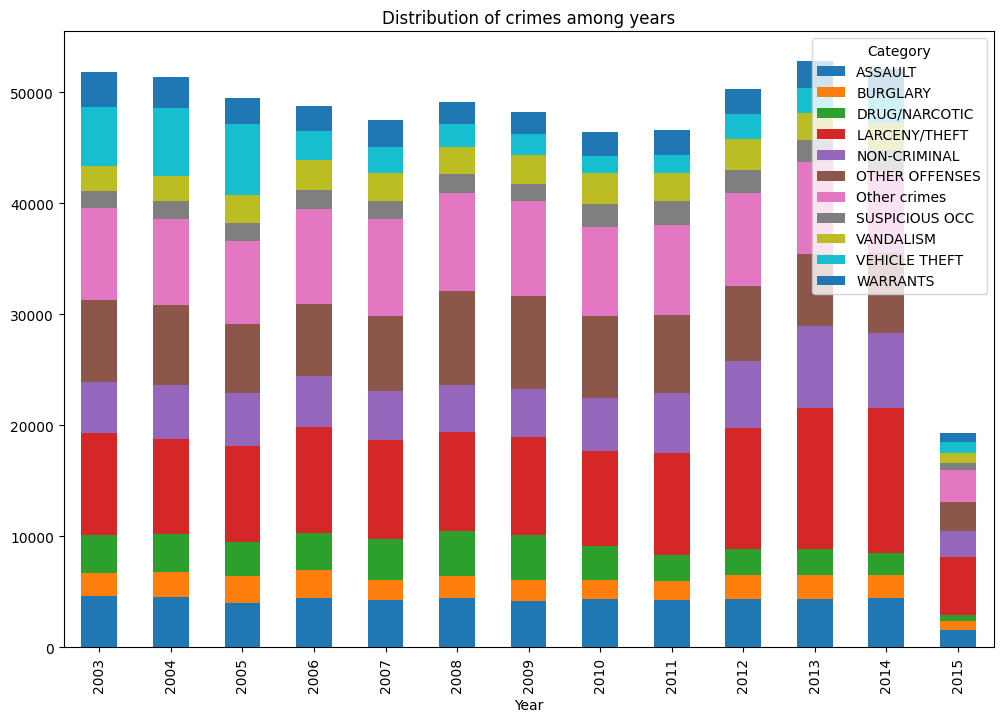

In [14]:
def crime_distribution_among_years(df_copy_top_10, plot = True):
    if plot:
        df_copy_top_10.groupby(['Year','Category'])\
                        .agg({'Resolution':'count'})\
                        .pivot_table(index='Year',columns='Category')['Resolution']\
                        .plot(kind='bar',stacked=True,figsize=(12,8))

        plt.title('Distribution of crimes among years')
        plt.show()

crime_distribution_among_years(sfcrime_train_top_10, plot = plot)

From 2003 and 2014 the total number of crime is quite constant, as the variation between number of crimes does not change in a significative way. If we also check the differnt kinds of crime (represented in the graph as different colors) we can observe that also their distribution is nearly the same in all years. 
The figure reports just one exeptional year: 2015. The decrease in the number of crimes observed in 2015 may be due to the dataset's limitations, which only encompass crimes until May 2015. This may have resulted in a lower count for that year.

### Distribution of crimes among hours

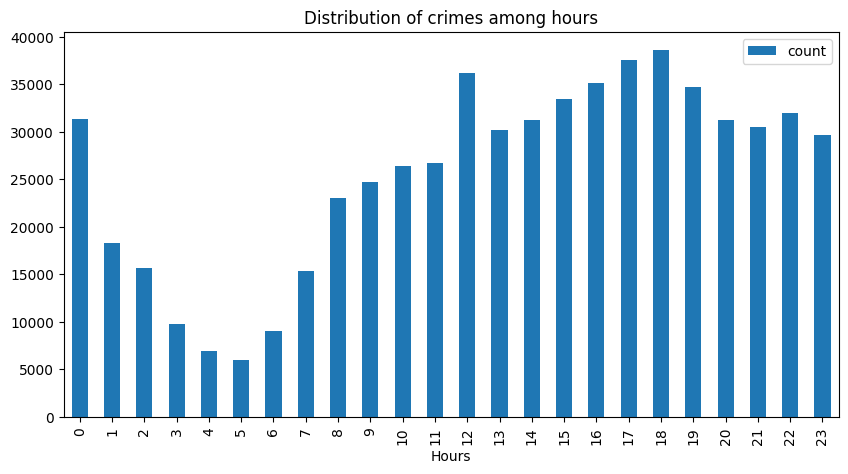

In [15]:
def crime_distribution_among_hours(df, plot = True):
    if plot:
        df.groupBy("Hour").count().orderBy("hour", ascending=True).toPandas().plot(kind='bar', x='Hour', y='count', figsize=(10,5))
        plt.title('Distribution of crimes among hours')
        plt.xlabel('Hours')
        plt.show()

crime_distribution_among_hours(sfcrime_train, plot = plot)

Studying the distribution of crime between the hours of a day it can be seen that the number of crimes differs depending on the time of the day. Indeed from early morning, like 1am, the number of crimes fastly decreases, until reaching a minimum at 5am and then it starts increasing again. This is presumibly due to the fact that most of the people from 1am to 5am is asleep. From 6am the crimes increases, and they reach the peak at 18pm, then they start decreasing again.

### Distribution of crimes among days

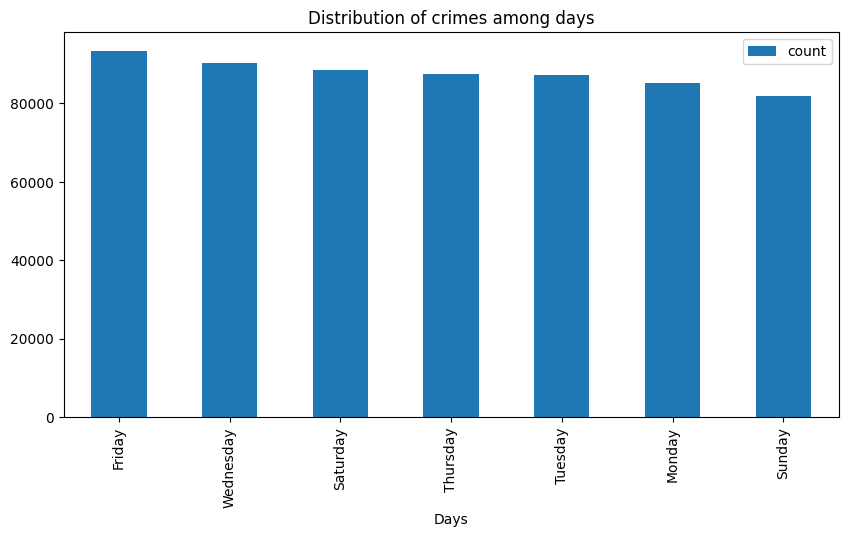

In [16]:
def crime_distribution_among_days(df, plot = True):
    if plot:
        df.groupBy('DayOfWeek').count().orderBy('count', ascending=False).toPandas().plot(kind='bar', x='DayOfWeek', y='count', figsize=(10, 5))
        plt.title('Distribution of crimes among days')
        plt.xlabel('Days')
        plt.show()

crime_distribution_among_days(sfcrime_train, plot = plot)

The total number of crime for each day of the week is quite stable.

### Trends of crimes during the week

In [17]:
def weekly_trend(df, categories):
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    axs = axs.flatten()
    
    for i, category in enumerate(categories):
        sfcrime_category = df[df['Category'] == category]
        category_counts = sfcrime_category.groupby(['DayOfWeek', 'Category']) \
                                            .agg({'Resolution': 'count'}) \
                                            .pivot_table(index='DayOfWeek', columns='Category')['Resolution'] \
                                            .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
        
        ax = axs[i]
        category_counts.plot(kind='line', ax=ax)
        ax.set_title('Weekly trend of the category: ' + category)
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

def plot_trends(df, categories, plot = True):
    if plot:        
        weekly_trend(df, categories)


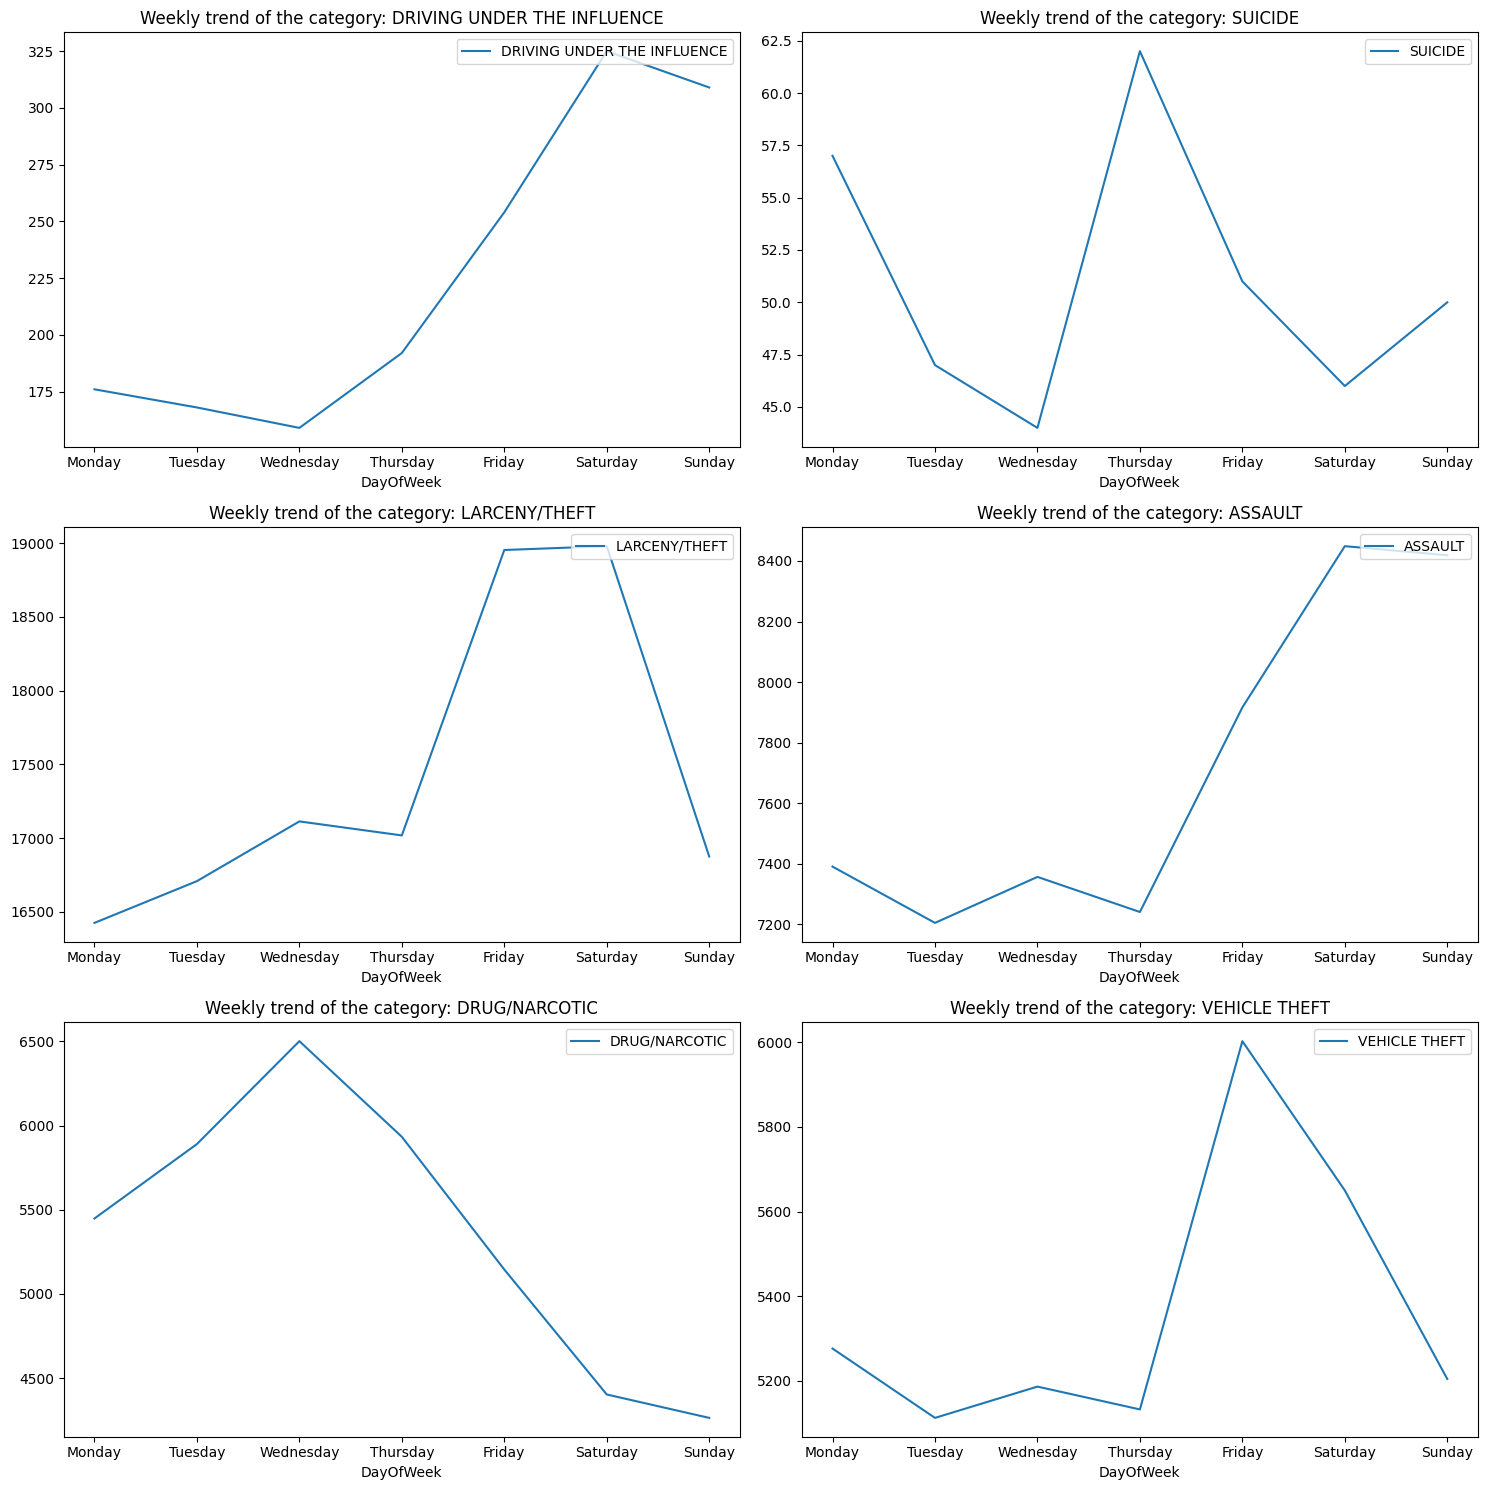

In [18]:
categories = ['DRIVING UNDER THE INFLUENCE', 'SUICIDE', 'LARCENY/THEFT', 'ASSAULT', 'DRUG/NARCOTIC', 'VEHICLE THEFT']

plot_trends(sfcrime_train_pd, categories, plot = plot)

We can observe that most of the crimes are committed during the last part of the week, namely from friday to saturday. 
In particular for example if we study the weekly trend for 'DRIVING UNDER THE INFLUENCE', there is an evident peak during the weekend, from friday to sunday. 

### Distribution of crimes among different addresses

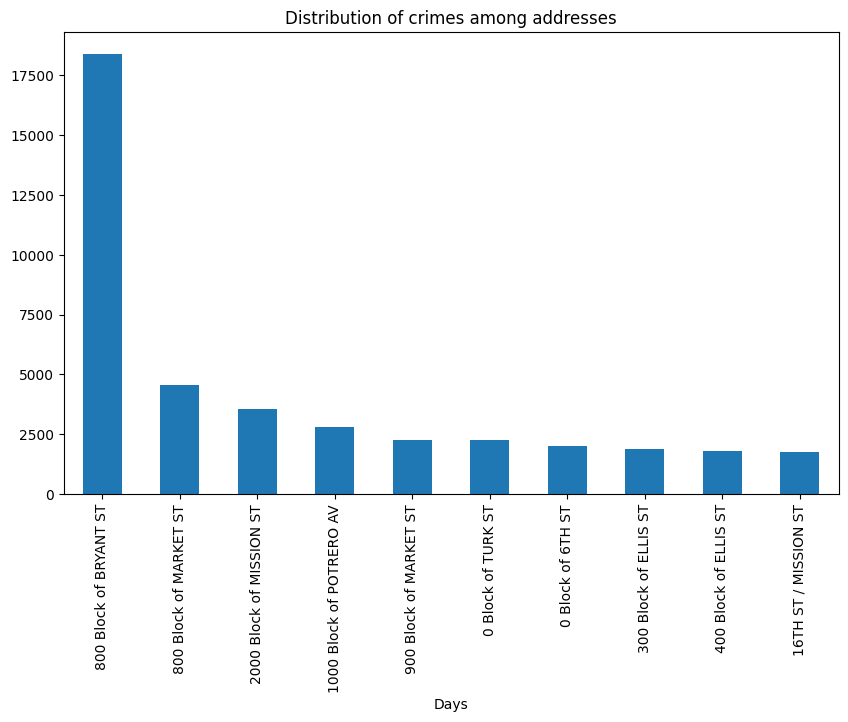

In [19]:
def crime_distribution_among_addresses(df_top_10, plot = True):
    if plot:
        df_top_10['Address'].value_counts().head(10).plot(kind='bar',figsize=(10,6))
        plt.title('Distribution of crimes among addresses')
        plt.xlabel('Days')
        plt.show()

crime_distribution_among_addresses(sfcrime_train_top_10, plot = plot)

The graph shows that the higher number of crimes occur in addresses containing the word "_block_". This suggests that the presence of this word in an address may be a useful feature to extract when analyzing crime data.

One approach would be to **create a binary feature** representing the presence or absence of the word "block", setting it to 1 if the word appears in the address and 0 if it does not.

### How the crimes have been resolved?


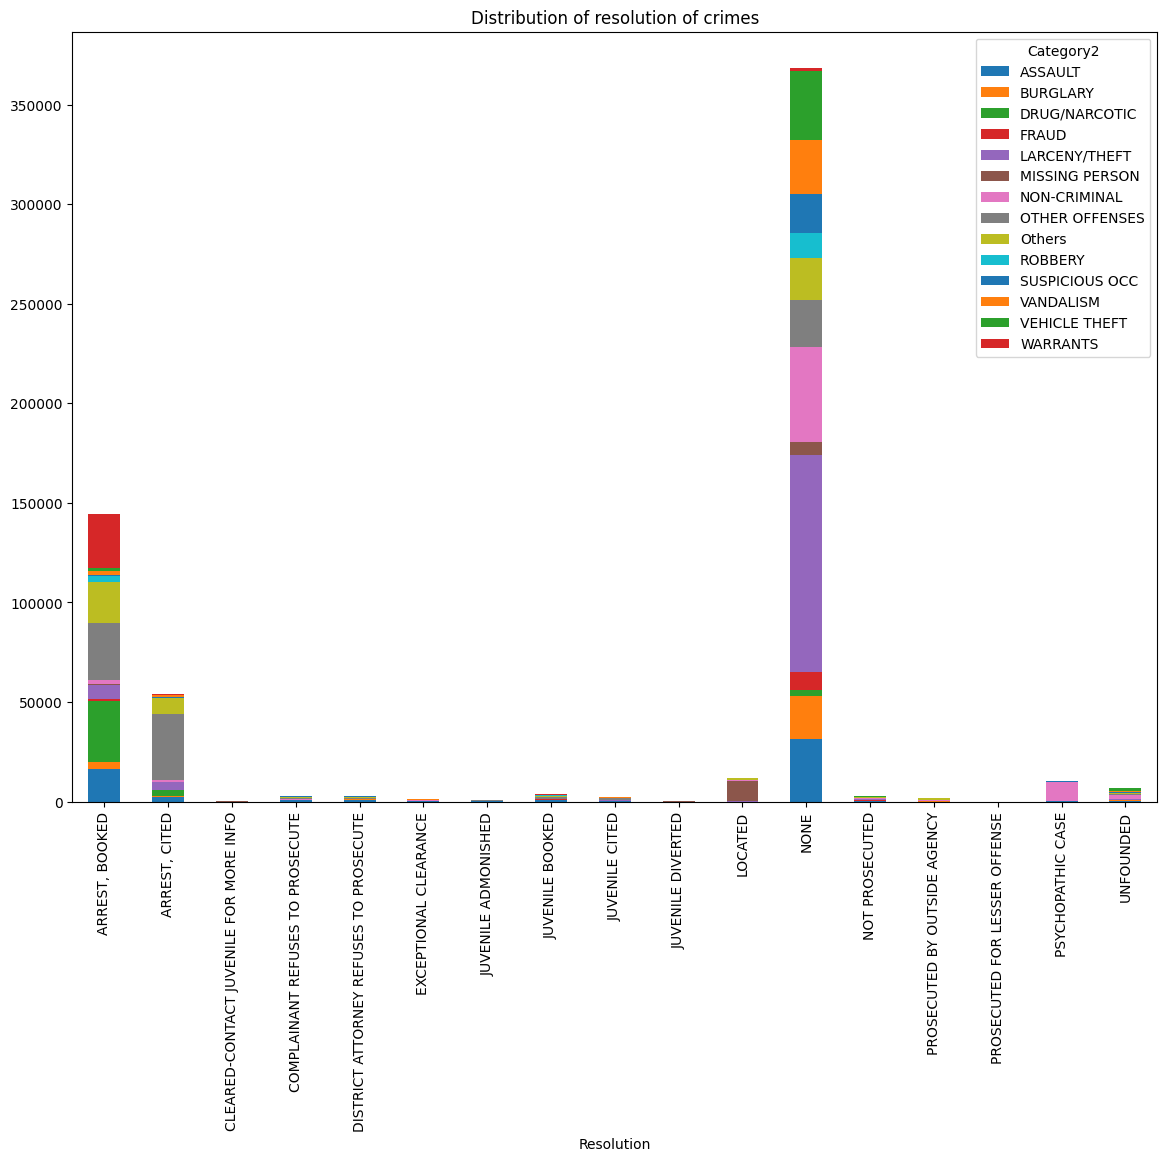

In [20]:
def crime_distribution_resolution(df, plot = True):
    if plot:
        cats_relevant = df['Category'].value_counts()[df['Category'].value_counts() > 10000].index
        df['Category2'] = df['Category'].apply(lambda x: 'Others' if x not in cats_relevant else x)
        df['Category2'].unique()

        df.groupby(['Resolution','Category2']).\
            agg({'PdDistrict':'count'}).\
            pivot_table(index='Resolution',columns='Category2')['PdDistrict'].\
            plot(kind='bar',stacked=True,figsize=(14,10))

        plt.title('Distribution of resolution of crimes')
        plt.show()

crime_distribution_resolution(sfcrime_train_pd, plot = plot)

The graph shows that most crimes have been solved with 'none'. This means that the majority of crimes have not yet been solved.

# Re-process the dataset after having inspected it: 
- **Convert columns to categorical**: this improves memory usage and computational speed, ensures correct data interpretation and increases predictive accuracy.
- **String processing** pipeline: the 'Descript' column is composed of strings, its values are processed following two different pipelines for the _Bag-of-Word_ approach and the _TF-IDF_ approach.
- **Extract block feature** from the address (as explained in the dataset inspection).
- **Drop unused columns**

In [ ]:
# Transform columns (PdDistrict, Category, Resolution, DayOfWeek) to categorical
district_indexer = StringIndexer(inputCol="PdDistrict", outputCol="PdDistrict_cat")
category_indexer = StringIndexer(inputCol="Category", outputCol="Category_cat")
resolution_indexer = StringIndexer(inputCol="Resolution", outputCol="Resolution_cat")
day_indexer = StringIndexer(inputCol="DayOfWeek", outputCol="DayOfWeek_cat")

# Preprocess Descript column with tokenizer
regexTokenizer = Tokenizer(inputCol="Descript", outputCol="Descript_token")

# Bag of words approach: emphasizes word occurrence but doesn't consider their relative importance across the corpus and it treats all words equally within a document.
vectorizer = CountVectorizer(inputCol="Descript_token", outputCol="Descript_vec")

# TF-IDF approach: assigns higher weights to terms that are frequent in a document but rare in the corpus. 
hashingTF = HashingTF(inputCol="Descript_token", outputCol="Descript_tf", numFeatures=1000)
idf = IDF(inputCol="Descript_tf", outputCol="Descript_tfidf")

pipeline = Pipeline(stages=[regexTokenizer, vectorizer, district_indexer, category_indexer, resolution_indexer, day_indexer])
sfcrime = pipeline.fit(df_sfcrime).transform(df_sfcrime)

pipeline_tfidf = Pipeline(stages=[regexTokenizer, hashingTF, idf, district_indexer, category_indexer, resolution_indexer, day_indexer])
scrime_tfidf = pipeline_tfidf.fit(df_sfcrime).transform(df_sfcrime)

def drop_and_extract(sfcrime, approach = "bow"):
    
    # Block feature extraction: 1 if block present, 0 otherwise
    sfcrime = sfcrime.withColumn('Block', when(sfcrime.Address.like("%Block%") , lit(1)).otherwise(lit(0)))
    
    # Drop no more needed columns
    sfcrime = sfcrime.drop("PdDistrict")\
                        .drop("Category")\
                        .drop("DayOfWeek")\
                        .drop("Resolution")\
                        .drop("Descript")\
                        .drop("Descript_token")\
                        .drop("Address") # Drop the 'address' column since we already have (x, y) coordinates and the block feature
    
    if approach == "tfidf":
        sfcrime = sfcrime.drop("Descript_tf")
        
    return sfcrime

sfcrime = drop_and_extract(sfcrime)
sfcrime_tfidf = drop_and_extract(scrime_tfidf, approach = "tfidf")

# Dataset requirements

In [23]:
print('Number of features: ', len(sfcrime.columns))
print(sfcrime.columns)

print('Total number of records: ', sfcrime.count())

print('Product of the number of features and the number of records: ', len(sfcrime.columns) * sfcrime.count())

Number of features:  11
['Hour', 'Month', 'Year', 'X_Scaled', 'Y_Scaled', 'Descript_vec', 'PdDistrict_cat', 'Category_cat', 'Resolution_cat', 'DayOfWeek_cat', 'Block']


Total number of records:  875659


Product of the number of features and the number of records:  9632249


The dataset originally combined the hour, month, and year features into a single feature. Therefore, we consider a total of 9 features for the project requirement, resulting in a product of **7880931** records and features.

# Prepare data for ML algorithms
- **RFormula**: it simplifies and standardizes the process of feature engineering, encodes categorical variables, and structures data for machine learning models, thereby streamlining the development and deployment of models within the Spark MLlib framework.
- **Standardize features**: standardization is an important step in many machine learning algorithms, especially those that involve distance-based metrics or gradient-based optimization, as it helps ensure that all features have a similar scale.
- **Train/Test split**
- **Repartition**: it helps in avoiding out-of-memory errors by distributing data evenly across partitions, preventing the overloading of resources on a single executor.
- Definition of an **evaluation function**: it calculates the *F1-score* and the *accuracy* for each model on the basis of the results obtained; in particular, it also calculates the _log-loss_ for those models that do not use the One-vs-Rest approach, since they do not return the 'probabilities' column, which is essential for calculating the log-loss.

In [5]:
rf = RFormula(formula="Category_cat ~ .")

# Bag of words approach
rf_transformed = rf.fit(sfcrime).transform(sfcrime)
rf_sfcrime = rf_transformed.selectExpr("features", "label")

# TF-IDF approach
rf_transformed = rf.fit(sfcrime_tfidf).transform(sfcrime_tfidf)
rf_sfcrime_tfidf = rf_transformed.selectExpr("features", "label")

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
rf_sfcrime_scaled = scaler.fit(rf_sfcrime).transform(rf_sfcrime).selectExpr("scaledFeatures", "label") 

# Split the data into training and test sets (30% held out for testing)
(rf_sfcrime_train, rf_sfcrime_test) = rf_sfcrime.randomSplit([0.7, 0.3], seed=seed)
(rf_sfcrime_scaled_train, rf_sfcrime_scaled_test) = rf_sfcrime_scaled.randomSplit([0.7, 0.3], seed=seed)
(rf_sfcrime_tfidf_train, rf_sfcrime_tfidf_test) = rf_sfcrime_tfidf.randomSplit([0.7, 0.3], seed=seed)

# Repartition the data
rf_sfcrime_train = rf_sfcrime_train.repartition(100)
rf_sfcrime_scaled_train = rf_sfcrime_scaled_train.repartition(100)
rf_sfcrime_tfidf_train = rf_sfcrime_tfidf_train.repartition(100)

In [25]:
rf_sfcrime_train.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1095,[0,1,2,3,4,...|  3.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...| 15.0|
|(1095,[0,1,2,3,4,...|  3.0|
|(1095,[0,1,2,3,4,...|  2.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  7.0|
|(1095,[0,1,2,3,4,...|  6.0|
|(1095,[0,1,2,3,4,...|  3.0|
|(1095,[0,1,2,3,4,...|  3.0|
|(1095,[0,1,2,3,4,...|  7.0|
|(1095,[0,1,2,3,4,...| 14.0|
|(1095,[0,1,2,3,4,...|  1.0|
|(1095,[0,1,2,3,4,...|  7.0|
|(1095,[1,2,3,4,33...|  9.0|
|(1095,[0,1,2,3,4,...| 17.0|
|(1095,[1,2,3,4,28...| 12.0|
|(1095,[0,1,2,3,4,...|  5.0|
|(1095,[0,1,2,3,4,...|  1.0|
+--------------------+-----+
only showing top 20 rows



In [6]:
def evaluation(results, model_name, oneVsRest = False):
    # Compute accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(results)
    print("Accuracy of model %s = %g" % (model_name, accuracy))

    # Compute F1 score
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score = evaluator.evaluate(results)
    print("F1 score of model %s = %g" % (model_name, f1_score))
    
    # Compute logloss 
    if oneVsRest == False:
        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="logLoss")
        log_loss = evaluator.evaluate(results)
        print("Log Loss of model %s = %g" % (model_name, log_loss))
    
        return accuracy, log_loss, f1_score
    
    return accuracy, f1_score     

# Exam

## Decision Tree Classifier
Decision trees are versatile machine learning algorithms that can be used for both binary and multi-label classification problems. Decision trees for multi-label classification have several advantages, including:
- Interpretability: Decision trees are often easy to interpret, as they can be represented as a series of rules or conditions. 
- Scalability: Decision trees can be used with large datasets, as they can be constructed efficiently using divide-and-conquer techniques.

However, they also have some limitations, including:
- Overfitting: Decision trees can easily overfit to the training data.
- Sensitivity to feature scaling: Decision trees can be sensitive to the scaling of features, as small changes in feature values can have a large impact on the model's predictions.

Despite these limitations, decision trees are a **powerful and versatile tool for multi-label classification**.

In order to select the best parameters for the DecisionTree Classifier we perform parameter tuning using **k- fold Cross Validation**, where the data is divided into k folds. The model is then trained on k-1 folds and evaluated on the remaining fold. This process is repeated k times, using different folds each time. The overall performance of the model is then estimated by averaging the performance scores from all k folds. This gives a more accurate estimate of the model's generalization performance than simply training the model on all of the data and evaluating it on a separate hold-out dataset.

The parameters we want to tune are *maxDepth* and *maxBins*. 

In [5]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", seed=seed)

# Define the grid of parameters to test
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [6, 8, 10]) \
                                .addGrid(dt.maxBins, [32, 128, 256]) \
                                .build()

# Cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  
cvModel_dt = crossval.fit(rf_sfcrime_train) 

# Evaluate the best model
best_dt_model = cvModel_dt.bestModel
best_maxdepth_param = best_dt_model.getOrDefault("maxDepth")
best_maxbins_param =  best_dt_model.getOrDefault("maxBins")
print("Best maxDepth Parameter:", best_maxdepth_param)
print("Best maxBins Parameter:", best_maxbins_param) 

Best maxDepth Parameter: 10
Best maxBins Parameter: 256


We found that the best parameters are:
- *maxDepth* = 10
- *maxBins* = 256

Now we can train the model and evaluate its performances.

In [11]:
dt_classifier = DecisionTreeClassifier(maxDepth=best_maxdepth_param, maxBins=best_maxbins_param, labelCol="label", featuresCol="features", seed=seed)
dt_Tr = dt_classifier.fit(rf_sfcrime_train)

results_dt = dt_Tr.transform(rf_sfcrime_test)

In [12]:
# Evaluate the model
acc_dt, log_dt, f1_dt = evaluation(results_dt, 'Decision Tree')
dt_results = {'f1': f1_dt, 'accuracy': acc_dt, 'logloss': log_dt}

Accuracy of model Decision Tree = 0.700843


F1 score of model Decision Tree = 0.705631


Log Loss of model Decision Tree = 1.00623


## Random forest
Random forests are particularly well-suited for multi-label classification because they are able to handle complex relationships between features and labels. They are also relatively robust to overfitting, making them a good choice for tasks with limited training data.

**Training Phase**:
- Build a random forest by constructing *multiple decision trees*.
- Each decision tree is trained on a randomly selected subset of features and labels from the training data.

**Prediction Phase**:
- For a new input instance, each decision tree in the forest makes a prediction for each label.
- The forest averages the predictions of all decision trees to determine the final prediction for each label.

Random forests are powerful and versatile machine learning algorithms that excel in multi-label classification problems. Their robustness to overfitting, ability to handle complex relationships, partial interpretability, and scalability make them well-suited for a wide range of applications.

To get the best results from the model, we use **cross-validation** to find the best parameters.

The parameters we want to optimize are _numTrees_, _maxDepth_ and _maxBins_.

In [8]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Cross validation for Random Forest
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [50, 90, 120]) \
                                .addGrid(rf.maxDepth, [4, 6, 8]) \
                                .addGrid(rf.maxBins, [32, 128, 256]) \
                                .build()

# Cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

#cvModel_rf = crossval.fit(rf_sfcrime_scaled_train)
cvModel_rf = crossval.fit(rf_sfcrime_train)

# Evaluate the best model
best_rf_model = cvModel_rf.bestModel
best_numtrees_param = best_rf_model.getOrDefault("numTrees")
best_maxdepth_param = best_rf_model.getOrDefault("maxDepth")
best_maxbins_param = best_rf_model.getOrDefault("maxBins")
print("Best numTrees Parameter:", best_numtrees_param)
print("Best maxDepth Parameter:", best_maxdepth_param)
print("Best maxBins Parameter:", best_maxbins_param)

Best numTrees Parameter: 120
Best maxDepth Parameter: 8
Best maxBins Parameter: 256


We found that the best parameters are:
- _numTrees_ = 120
- *maxDepth* = 8
- *maxBins* = 256

Now we can train the model and evaluate its performances.

In [10]:
rf_classifier = RandomForestClassifier(numTrees=best_numtrees_param, maxDepth=best_maxdepth_param, maxBins = best_maxbins_param, labelCol="label", featuresCol="features", seed=seed)
rf_Tr = rf_classifier.fit(rf_sfcrime_train)

results_rf = rf_Tr.transform(rf_sfcrime_test)

In [11]:
# Evaluate the model
acc_rf, log_rf, f1_rf = evaluation(results_rf, 'Random Forest')
rf_results = {'f1': f1_rf, 'accuracy': acc_rf, 'logloss': log_rf}

Accuracy of model Random Forest = 0.832999


F1 score of model Random Forest = 0.805835


Log Loss of model Random Forest = 1.33469


In this case, random forest clearly outperforms decision trees, with an accuracy of 83.3% compared to 70.1%. This suggests that random forest is generally a better choice for this multi-label classification task.

## Naive Bayes

Naive Bayes is a probabilistic classification algorithm that is based on **Bayes' theorem** to calculate class probabilities based on observed features and prior probabilities. During the training phase it learns from data by computing class and feature probabilities, while in the prediction step it predicts the class for new instances by calculating posterior probabilities using learned probabilities.

It is a popular choice for multi-label classification because it is relatively simple to implement, interpretable, and scalable. However, it also has some limitations, such as the **strong independence assumption**, which can lead to inaccurate predictions, and the handling of rare features. Despite these limitations, Naive Bayes is a versatile and relatively efficient algorithm for multi-label classification. 

Firstly, we perform *hyperparameter tuning* in order to decide which smoothing parameter is the best for our purposes.

In [12]:
nb = NaiveBayes(labelCol="label", featuresCol="features")

# Define the grid of parameters to test
paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
                                .build()

# Cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 
cvModel_nb = crossval.fit(rf_sfcrime_train)

# Evaluate the best model
best_nb_model = cvModel_nb.bestModel
best_smoothing_param = best_nb_model.getOrDefault("smoothing")
print("Best Smoothing Parameter:", best_smoothing_param)

Best Smoothing Parameter: 0.0


The best *smoothing parameter* turned out to be 0.0. <br>
This means that no smoothing needs to be applied to our model, presumably because the training data is large and diverse enough that the calculated probabilities are not affected by zero counts. We use this parameter to define and train the Naive Bayes model.

In [13]:
nb = NaiveBayes(modelType="multinomial", featuresCol="features", smoothing=best_smoothing_param)
nb_Tr = nb.fit(rf_sfcrime_train)

results_nb = nb_Tr.transform(rf_sfcrime_test)

In [14]:
# Evaluate the model
acc_nb, log_nb, f1_nb = evaluation(results_nb, 'Naive Bayes')
nb_results = {'f1': f1_nb, 'accuracy': acc_nb, 'logloss': log_nb}

Accuracy of model Naive Bayes = 0.995229


F1 score of model Naive Bayes = 0.995504


Log Loss of model Naive Bayes = nan


## Logistic Regression

Logistic regression is a statistical model that is used for binary classification but it can also be extended to handle multi-label classification problems, in this case it is known as _**Multinomial Logistic Regression**_. 

Logistic regression for multi-label classification typically follows a three-step process:

1. **Build Separate Models:** For each label, build a logistic regression model to predict the presence or absence of that label.

2. **Predict Probabilities:** For a new instance, calculate the probability of each label being present given the instance's features. This is done by using the logistic function to transform the linear combination of features into a probability between 0 and 1.

3. **Thresholding:** For each label, apply a threshold to the predicted probability to determine whether the label is predicted to be present or absent.

Overall, logistic regression is a versatile and well-established algorithm for multi-label classification. Its interpretability, scalability, and flexibility make it suitable for a wide range of applications. However, it is important to be aware of its limitations, such as the independent feature assumption and limited representation power, when choosing it for a specific task.

In this case we use Logistic Regression along with the *bag-of-words* approach, by vectorising the string features using the **CountVectorizer** which simply counts the number of times a word appears in a document.

Before starting to fit the model, we search for the best parameters to use via cross validation. In particular, we look for the following parameters: *maxIter*, *regParam* and *elasticNetParam*.

In [15]:
lr = LogisticRegression(featuresCol="features", labelCol="label") 

# Define the grid of parameters to test
paramGrid = ParamGridBuilder().addGrid(lr.maxIter, [10, 20, 30]) \
                                .addGrid(lr.regParam, [0.1, 0.3, 0.5]) \
                                .addGrid(lr.elasticNetParam, [0.0, 0.2, 0.4]) \
                                .build()

# Cross-validation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
cvModel_lr = crossval.fit(rf_sfcrime_train)

# Evaluate the best model
best_lr_model = cvModel_lr.bestModel
best_maxiter_param = best_lr_model.getOrDefault("maxIter")
best_regparam_param = best_lr_model.getOrDefault("regParam")
best_elasticnetparam_param = best_lr_model.getOrDefault("elasticNetParam")
print("Best maxIter Parameter:", best_maxiter_param)
print("Best regParam Parameter:", best_regparam_param)
print("Best elasticNetParam Parameter:", best_elasticnetparam_param)

Best maxIter Parameter: 10
Best regParam Parameter: 0.1
Best elasticNetParam Parameter: 0.0


We found that the best parameters are:
- *maxIter* = 10
- *regParam* = 0.1
- *elasticNetParam* = 0.0

Now we can train the model and evaluate its performances.

In [18]:
lr = LogisticRegression(featuresCol="features", maxIter=best_maxiter_param, regParam=best_regparam_param, elasticNetParam=best_elasticnetparam_param)
lr_Tr = lr.fit(rf_sfcrime_train)

results_lr = lr_Tr.transform(rf_sfcrime_test)

In [19]:
# Evaluate the model
acc_lr, log_lr, f1_lr = evaluation(results_lr, 'Logistic Regression')
lr_results = {'f1': f1_lr, 'accuracy': acc_lr, 'logloss': log_lr}

Accuracy of model Logistic Regression = 0.995748


F1 score of model Logistic Regression = 0.995804


Log Loss of model Logistic Regression = 0.206709


## Gradient-Boosted Tree classifier with One-vs-Rest

Gradient boosted trees (GBTs) are a type of ensemble learning algorithm that combines multiple decision trees to improve prediction accuracy. In multi-label classification, GBTs can be used to build a separate decision tree for each label. This approach is known as **one-vs-rest** (OVR) classification.

Gradient boosted trees can improve the performance of OVR classification by iteratively fitting decision trees to the residuals of previous predictions. This process helps to reduce the bias and variance of the overall model. Additionally, GBTs can handle complex relationships between features and labels, which can further improve performance.

The training time for Gradient Boosted Trees (GBT) can indeed be longer compared to simpler algorithms due to its sequential nature and the complexity of building multiple decision trees iteratively.

In [ ]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# Instantiate the One Vs Rest Classifier 
ovr = OneVsRest(classifier=gbt)
ovrModel = ovr.fit(rf_sfcrime_train)

results_gbtovr = ovrModel.transform(rf_sfcrime_test)

In [7]:
# Evaluate the model
acc_gbtovr, f1_gbtovr = evaluation(results_gbtovr, 'Gradient-Boosted tree classififer with One vs Rest', oneVsRest = True)
gbtovr_results = {'f1': f1_gbtovr, 'accuracy': acc_gbtovr, 'logloss': '-'}

Accuracy of model Gradient-Boosted tree classififer with One vs Rest = 0.995872
F1 score of model Gradient-Boosted tree classififer with One vs Rest = 0.995883


In [ ]:
# Save results in json format to avoid recomputing them
results_gbtovr.write.json("bigdata/BDA/results_gbtovr.json")

In [6]:
# Load the results from json file
results_gbtovr = spark.read.format("json")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path",f"bigdata/BDA/results_gbtovr.json/").load()

# Check that the results are loaded correctly
results_gbtovr.show()

+--------------------+-----+----------+--------------------+
|            features|label|prediction|       rawPrediction|
+--------------------+-----+----------+--------------------+
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  5.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  

# Project Work

## MultiLayerPerceptron


A multilayer perceptron (MLP) is a type of **artificial neural network** that can be used for both binary and multi-label classification tasks.

MLPs for multi-label classification typically follow a four-step process:
- Input Layer: the input layer receives the features of an input instance.
- Hidden Layers: one or more hidden layers of neurons are used to learn the relationships between the input features and the labels.
- Output Layer: the output layer produces a vector of predictions for each label.
- Sigmoid Activation function: the sigmoid activation function is used to map the output of the neurons in the hidden layer to a probability between 0 and 1 for each label.

Using a MLP in multilabel classification allows the learning of complex relationships between features and multiple labels simultaneously. However, it requires regularization and handling of imbalanced data to build robust models for multilabel classification tasks.

In [21]:
# Compute input_size based on the assembled features
input_size = len(rf_sfcrime_train.select("features").first()[0])

# Compute the number of classes
output_size = len(rf_sfcrime_train.select("label").distinct().collect())

We will train the model on scaled data: neural networks employ gradient-based optimization algorithms (e.g., stochastic gradient descent) to train the weights of a neural network.

In [ ]:
# Specify layers for the neural network: input layer of size 1095 (features), one intermediate of size 100 and output of size 39 (classes)
layers = [input_size, 100, output_size]

# Train the model on scaled data since it performs gradient-based optimization
trainer = MultilayerPerceptronClassifier(featuresCol='scaledFeatures', maxIter=100, layers=layers, blockSize=32, seed=seed)

model = trainer.fit(rf_sfcrime_scaled_train)
results_mlp = model.transform(rf_sfcrime_scaled_test)

In [9]:
# Evaluate the model
acc_mlp, log_mlp, f1_mlp = evaluation(results_mlp, 'MLP')
mlp_results = {'f1': f1_mlp, 'accuracy': acc_mlp, 'logloss': log_mlp}

23/12/30 17:07:13 WARN DAGScheduler: Broadcasting large task binary with size 1077.0 KiB
23/12/30 17:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1077.0 KiB


Accuracy of model MLP = 0.99955


23/12/30 17:07:26 WARN DAGScheduler: Broadcasting large task binary with size 1077.3 KiB


F1 score of model MLP = 0.999558


Log Loss of model MLP = 0.00117586


In [10]:
# Save the results
results_mlp.write.json("bigdata/results_mlp.json")

23/12/30 17:07:40 WARN DAGScheduler: Broadcasting large task binary with size 1294.2 KiB


In [3]:
# Load the results from json file
results_mlp = spark.read.format("json")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path",f"bigdata/results_mlp.json/").load()

## Logistic regression with TF-IDF features

As already said, Logistic Regression can be extended to be used for multi-class classification problems. We can try to use it along with a different vectorization of the string features, namely **TF-IDF Vectorizer**, which takes into account the importance of a word across the entire corpus besides its frequency within a document.

We use the same *hyperparameters* as in the previous fitting of the logistic regression in order to have more comparable results and to draw reliable conclusions about the best approach to use in this task to vectorise string features.

In [ ]:
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=best_maxiter_param, regParam=best_regparam_param, elasticNetParam=best_elasticnetparam_param) 

lr_tfidf_Tr = lr.fit(rf_sfcrime_tfidf_train)
results_lr_tfidf = lr_tfidf_Tr.transform(rf_sfcrime_tfidf_test)

In [17]:
# Evaluate the model
acc_lrtfidf, log_lrtfidf, f1_lrtfidf = evaluation(results_lr_tfidf, 'Logistic Regression with TF-IDF')
lrtfidf_results = {'f1': f1_lrtfidf, 'accuracy': acc_lrtfidf, 'logloss': log_lrtfidf}

Accuracy of model Logistic Regression with TF-IDF = 0.990074


F1 score of model Logistic Regression with TF-IDF = 0.989141


Log Loss of model Logistic Regression with TF-IDF = 0.258214


The performance are slightly lower compared to those obtained with a different tokenization of the 'Descript' column, the one using the *BoW* approach. This may be due to various reasons:
- *TF-IDF* tends to downweight words that are common across the corpus but may not carry much meaning. Logistic regression may perform better with *BoW* if these common words are important in the classification process. 
- Another potential explanation for the performance difference between *BoW* and *TF-IDF* with logistic regression could be attributed to linear separability: if the *TF-IDF* representation alters the data in a manner that reduces its linear separability for the given problem, *BoW* may outperform it.

However, the performance difference between *BoW* and *TF-IDF* can vary depending on the dataset, the task, and the inherent characteristics of the text data.

## Factorization Machines with One-vs-Rest

Factorization Machines are a type of machine learning model that can be used to model the interactions between features. They are based on the assumption that the value of a label is determined not only by the individual features, but also by the interactions between those features.

Combining Factorization Machines with the One-vs-Rest strategy enables the model to predict the presence or absence of multiple labels for a given instance efficiently, in this way an FM model is used to learn the feature interactions and an OVR classifier is used to combine the predictions for each label.

Here, we train the model on scaled data since it performs gradient-based optimization.

In [ ]:
fm = FMClassifier(labelCol="label", featuresCol="scaledFeatures", maxIter=100, stepSize=1, seed=seed)

# Instantiate the One Vs Rest Classifier
ovr_fm = OneVsRest(classifier=fm)

# Train the model and transform the test set
model_fm = ovr_fm.fit(rf_sfcrime_scaled_train)
results_fm = model_fm.transform(rf_sfcrime_scaled_test)

In [1]:
# Evaluate the model
acc_fm, f1_fm = evaluation(results_fm, 'Factorization Machines with One vs Rest', oneVsRest = True)
fm_results = {'f1': f1_fm, 'accuracy': acc_fm, 'logloss': '-'}

Accuracy of model Factorization Machines with One vs Rest = 0.996938
[Stage 11909:=============>                                         (1 + 3) / 4]
F1 score of model Factorization Machines with One vs Rest = 0.997071


In [ ]:
# Save results
results_fm.write.json("bigdata/results_fm.json")

In [ ]:
# Load the results from json file
results_fm = spark.read.format("json")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path",f"bigdata/results_fm.json/").load()

# Error analysis

In [4]:
def show_confusion_matrix(results):
  predictionAndLabels = results.select(['prediction', 'label']) 
  metrics = MulticlassMetrics(predictionAndLabels.rdd.map(tuple)) # rdd of (prediction, label) beacuse the input of MulticlassMetrics is an RDD of prediction and labels
  cm = metrics.confusionMatrix().toArray()
  # compute percentage in the confusion matrix
  cm = cm / cm.sum(axis=1)[:,None]

  label_names = df_sfcrime.groupby('category').count().toPandas()['category'].unique()
  df_cm = pd.DataFrame(cm, index = label_names, columns = label_names)
  sns.set(font_scale=0.1) 
  sns.set(rc={'figure.figsize':(15,10)})
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 5})
  plt.show()

## Exam - Error analysis

In [3]:
dt_results = {'f1': 0.705631, 'accuracy': 0.700843, 'logloss': 1.00623}
rf_results = {'f1': 0.805835, 'accuracy': 0.832999, 'logloss': 1.33469}
nb_results = {'f1': 0.995504, 'accuracy': 0.995229, 'logloss': 'nan'}
lr_results = {'f1': 0.995804, 'accuracy': 0.995748, 'logloss': 0.206709}
gbtovr_results = {'f1': 0.995883, 'accuracy': 0.995872, 'logloss': '-'}

results_exam =  {'Decision Tree': dt_results, 'Random Forest': rf_results, 'Naive Bayes': nb_results, 'Logistic Regression': lr_results, 'Gradient-Boosted tree classififer with One vs Rest': gbtovr_results}

# Convert the dictionary into DataFrame
results_exam_df = pd.DataFrame(results_exam).transpose()
results_exam_df

,f1,accuracy,logloss
Decision Tree,0.705631,0.700843,1.00623
Random Forest,0.805835,0.832999,1.33469
Naive Bayes,0.995504,0.995229,nan
Logistic Regression,0.995804,0.995748,0.206709
Gradient-Boosted tree classififer with One vs Rest,0.995883,0.995872,-


We plot the **multi class confusion matrix** for one of the best model found, namely the _Naive Bayes_. The multiclass confusion matrix is very useful in error analysis as it shows the number of times a particular crime was predicted correctly, incorrectly, or not at all. The rows of the matrix represent the actual crimes, while the columns represent the predicted crimes.

/opt/spark/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


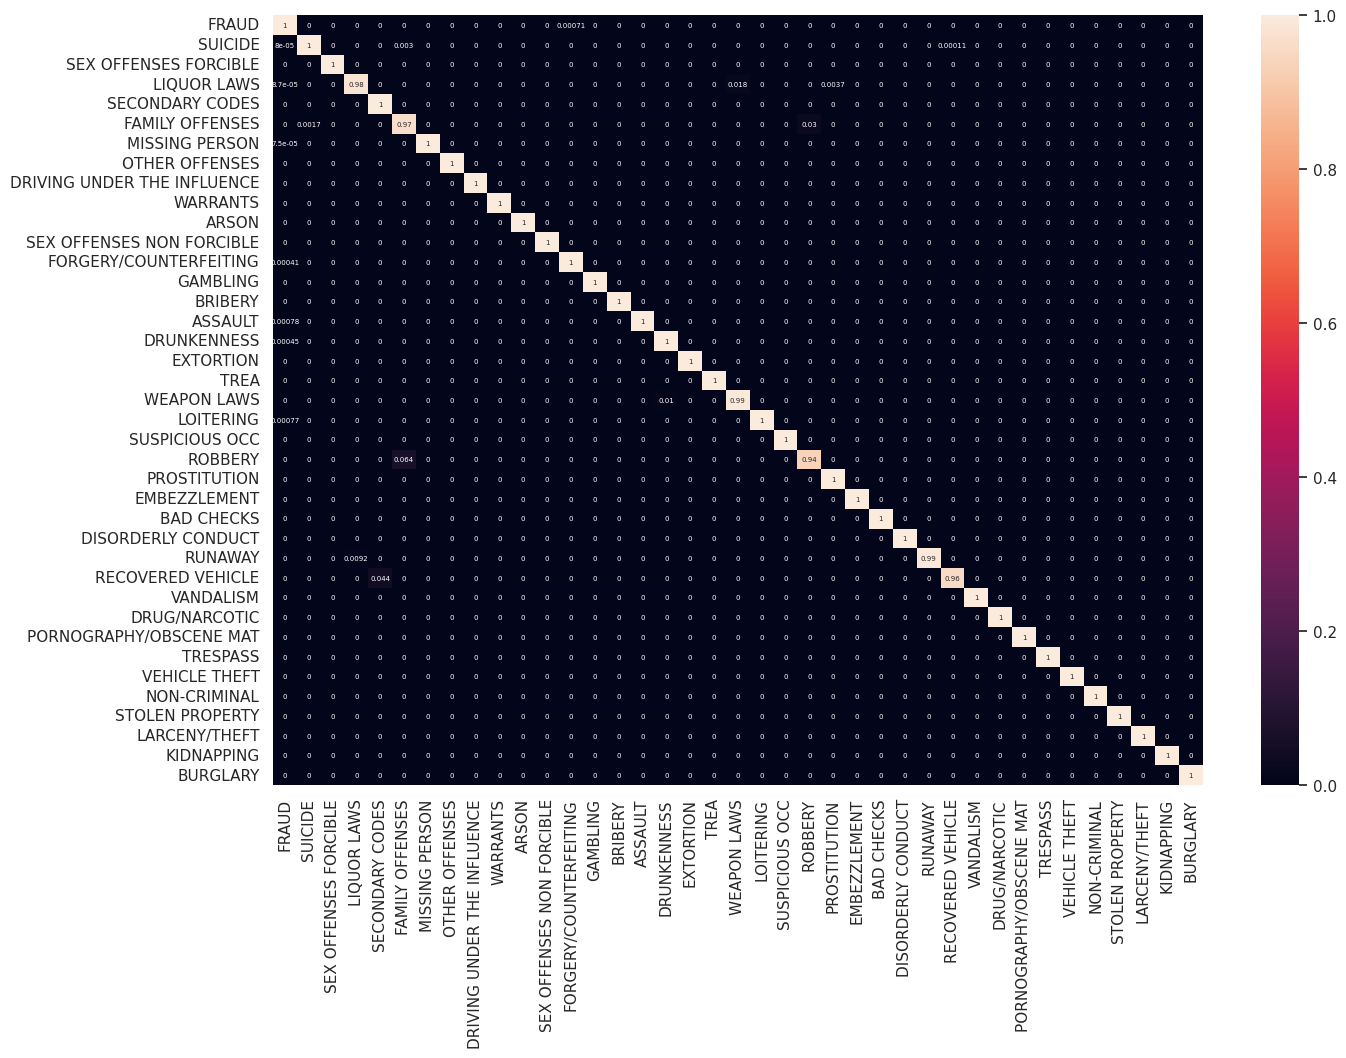

In [37]:
show_confusion_matrix(results_nb)

The multilabel confusion matrix results indicate that the classifier is proficient in predicting crimes with few misclassifications. However, there are some noticeable trends in the misclassifications. For instance, 'robbery' is frequently confused with 'family offenses', which is then confused with 'suicide'. Additionally, there is a misclassification between 'drunkness' and 'weapon laws'.

Below is the multi class confusion matrix for the model that performed the worst on the test set, namely the _Decision Tree Classifier_.

/opt/spark/python/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


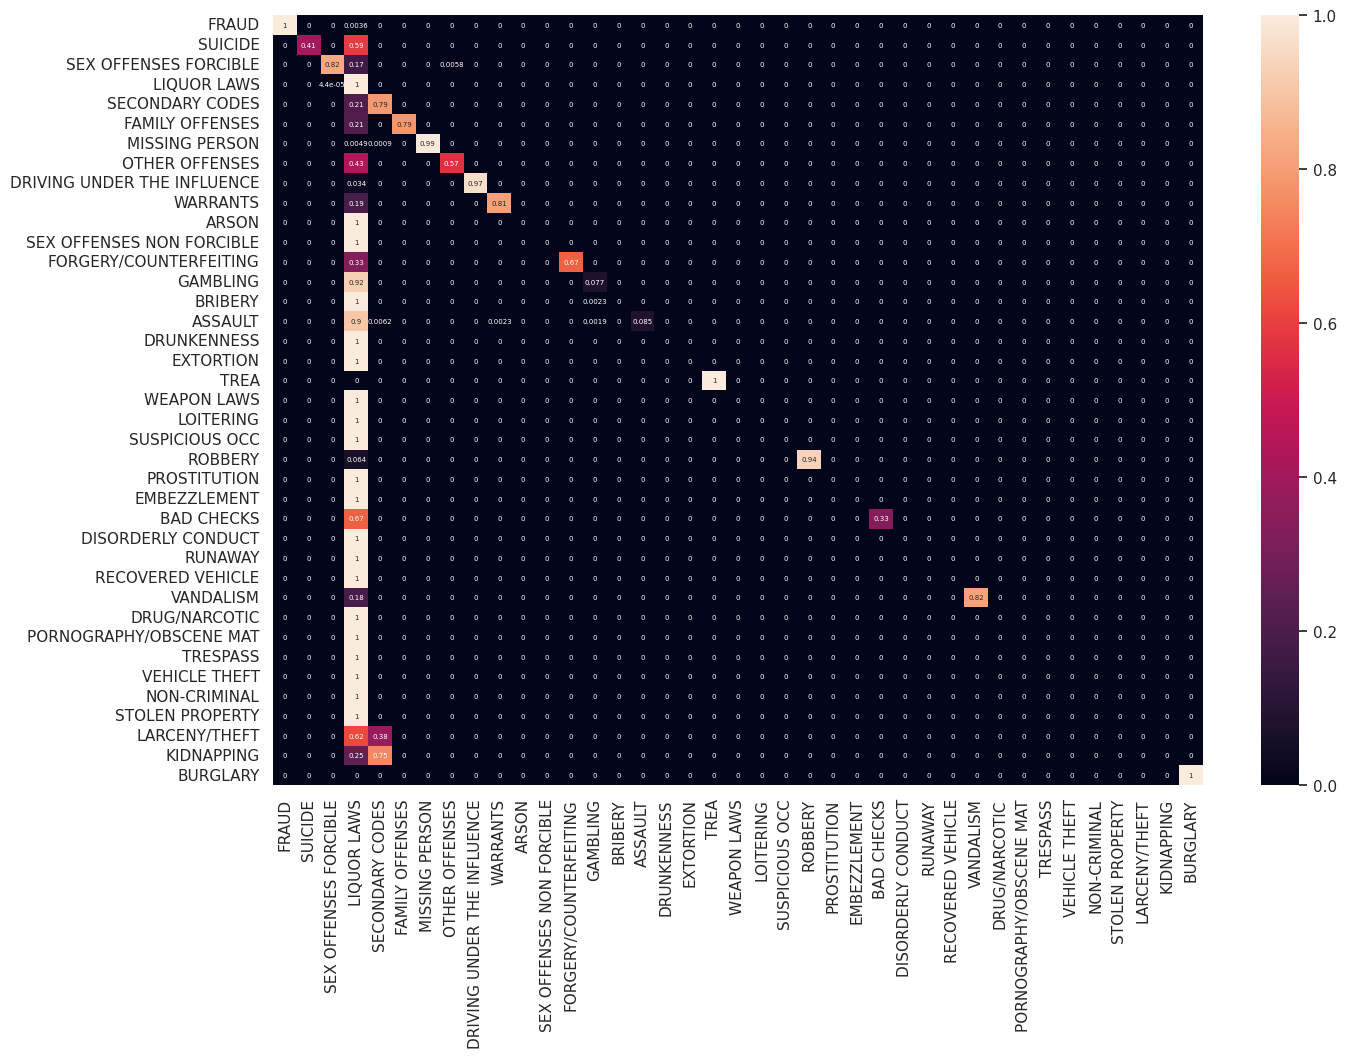

In [41]:
show_confusion_matrix(results_dt)

It is evident that there are numerous misclassification errors present, with the majority being caused by the model incorrectly classifying many crimes as 'Liquor laws'.

## Project work - Error analysis

In [4]:
mlp_results = {'f1': 0.999558, 'accuracy': 0.99955, 'logloss': 0.00117586}
lrtfidf_results = {'f1': 0.989141, 'accuracy': 0.990074, 'logloss': 0.258214}
fm_results = {'f1': 0.997071, 'accuracy': 0.996938, 'logloss': '-'}

results_project = {'MLP': mlp_results, 'Logistic Regression with TF-IDF': lrtfidf_results, 'Factorization Machines with One vs Rest': fm_results}

# Convert the dictionary into DataFrame
results_project_df = pd.DataFrame(results_project).transpose()
results_project_df

,f1,accuracy,logloss
MLP,0.999558,0.99955,0.001176
Logistic Regression with TF-IDF,0.989141,0.990074,0.258214
Factorization Machines with One vs Rest,0.997071,0.996938,-


We show the multi class confusion matrix for the best performing model: the _MultiLayer Perceptron Classifier_, with the highest F1-score (0.999), and the lowest log-loss (0.001).

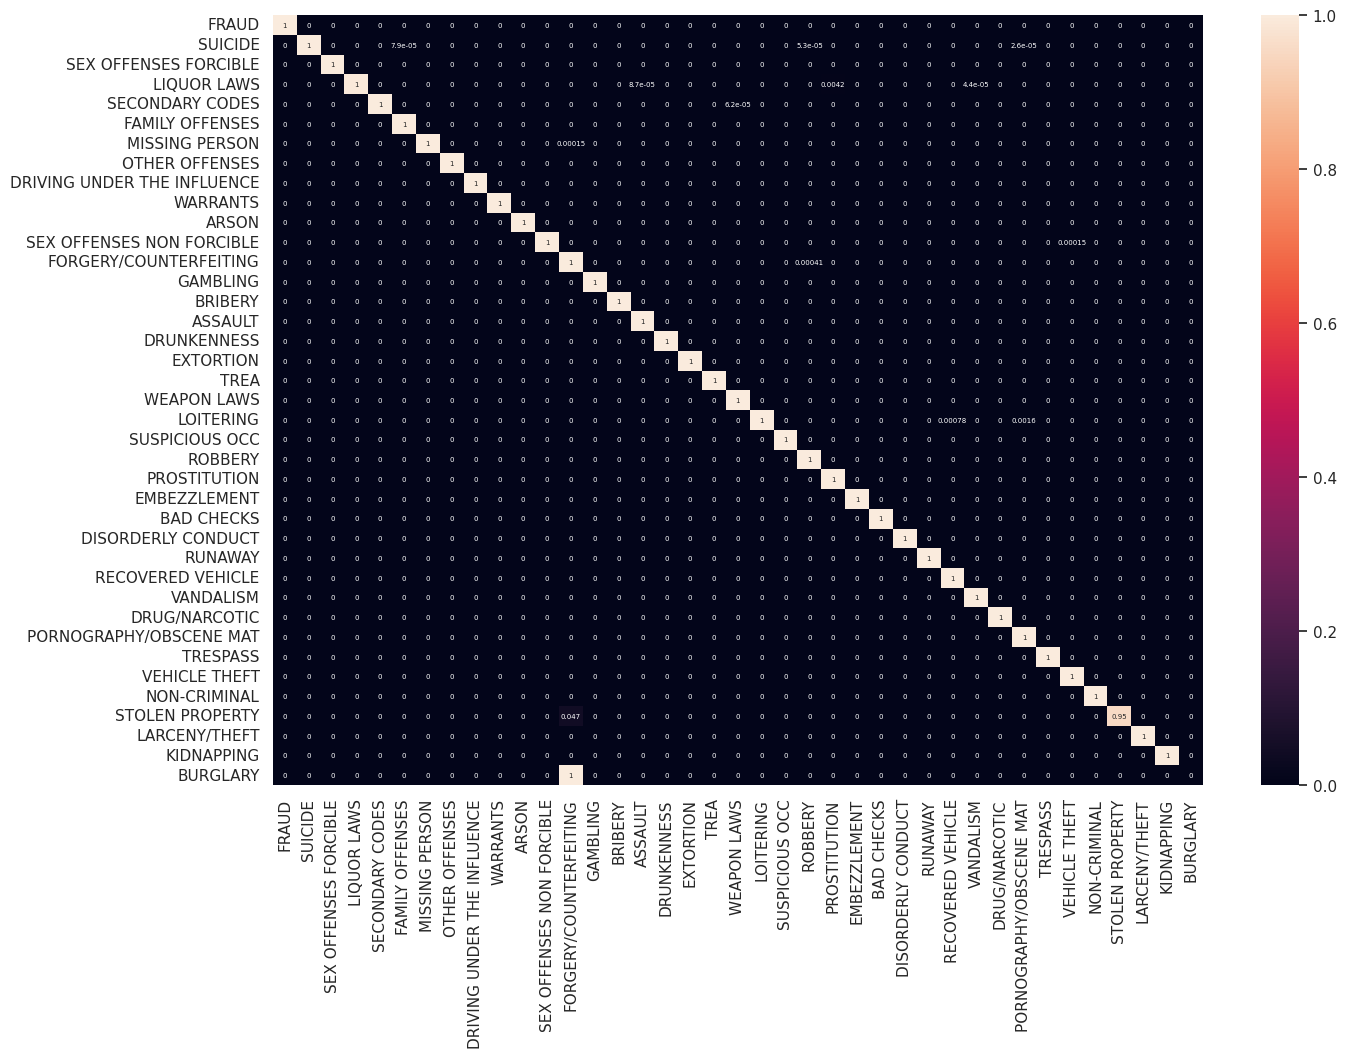

In [13]:
show_confusion_matrix(results_mlp)

The confusion matrix for MLP shows that the classifier performs indeed efficiently. However, there are few misclassifications that involve certain categories, such as 'Loitery' which is sometimes confused with 'Recovered vehicle', or 'Stolen property' which is sometimes erroneously classified as 'Forgery/counterfeiting'. Apart from those, the most evident misclassification is 'Burglary' which is always classified as 'Forgery/counterfeiting', meaning that the model wasn't able at all to learn its correct classification.